# <font color='green'>Tabalho de Conclusão de Curso - Ciência de Dados PUC MINAS</font>
Autor: Rodolpho Jayme Pacca - julho de 2021
## Processamento de Linguagem Natural
### Classificação de autoria textual a partir de embeddings treinados em Word2Vec (modalidade SkipGram)
Predição da autoria de tweets com base em um corpora treinado em uma rede neural Word2Vec na modalidade SkipGram

In [103]:
# Pacotes utilizados
import os
import collections
import math
import random
import re
import datetime as dt
import pandas as pd
import functools as func

# Os seguintes pacotes requerem instalação prévia (em ambiente conda, use "conda install -n <env> <pacote>")
import numpy as np
import tensorflow as tf
import matplotlib
import sklearn
import spacy
from matplotlib import pylab
from six.moves import range
from six.moves import xrange
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import LogisticRegression
import tweepy

%matplotlib inline

In [10]:
#Lingua portuguesa: Requer o pacote pt_core_news_sm (python -m spacy download pt_core_news_sm)
nlp = spacy.load("pt_core_news_sm")

## 1. Dataset
Abaixo utilizamos o módulo Tweepy para conectar à API do Twitter e gravar os arquivos no filesystem

In [227]:
consumer_key = 'XXXXXXXXXX'
consumer_secret = 'XXXXXXXXXX'
access_token = 'XXXXXXXXXX'
access_token_secret = 'XXXXXXXXXX'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

### 1.1. Extração de dados da API e persistência do respectivo dataset no sistema de arquivos do SO
O código utiliza a api user_timeline do Twitter para recuperar o histórico de tweets de autoria de 5 usuários que serão referenciados neste documento por siglas, conforme o dicionário abaixo

In [5]:
lista_autores = {'rc' : 'XXXXXXXXXX', 
                 'pd':'XXXXXXXXXX', 
                 'rm': 'XXXXXXXXXX', 
                 'av' : 'XXXXXXXXXX', 
                 'vm' : 'XXXXXXXXXX'}

In [ ]:
for aut, nome in lista_autores.items():
    count = 1
    for status in tweepy.Cursor(api.user_timeline, screen_name=nome, tweet_mode="extended", count=200).items():
        nome_arquivo= aut + '_' + format(count,'04d')
        new_file=open("tweeter_dataset/{0}/{1}.txt".format(aut, nome_arquivo),mode="w",encoding="utf-8")
        new_file.write(status.full_text)
        new_file.close()
        count = count + 1
    print("Total de arquivos criados para o autor {0}: {1}".format(aut, count))

## 2. Carregando os dados do sistema de arquivos
Carrega os dados do dos datasets para cada autor, aproveitando para realizar as primeiras transformações de pré-processamento, como a conversão dos caracteres para caixa baixa, além da retirada de números, de links e de menções, típicas do formato (ex: @xxx)

In [133]:
corpora = {}
arquivos_a_ler = 3001
for aut in lista_autores.keys():
    corpus = []
    for arq in range(1, arquivos_a_ler):
        with open('tweeter_dataset/' + aut + '/' + aut + '_' + format(arq,'04d')+'.txt', encoding='utf8') as f:
            file_string = f.read()
            file_string = file_string.lower() #normaliza para caixa baixa
            file_string = re.sub(r'\b\d+\b', '', file_string) #retira números
            file_string = re.sub(r'\b\d\dh\d\d\b\s', '', file_string) #retira hora no formato 00h00
            file_string = re.sub(r'https?:\/\/[0-9A-Za-z\.\/\._\-\~]+', '', file_string) #retirada de links ex:https://...
            file_string = re.sub(r'@[0-9A-Za-z\._\-\:]+\s', '', file_string) #retirada de menções ex: @usuario
            corpus.append(file_string)
    corpora[aut] = corpus
    print('Concluída a leitura de {0} arquivos para o autor: {1}'.format(len(corpora[aut]), aut))

Concluída a leitura de 3000 arquivos para o autor: rc
Concluída a leitura de 3000 arquivos para o autor: pd
Concluída a leitura de 3000 arquivos para o autor: rm
Concluída a leitura de 3000 arquivos para o autor: av
Concluída a leitura de 3000 arquivos para o autor: vm


## 3. Separação de arquivos para teste
Separa 20% dos arquivos para teste de forma aleatória

In [134]:
corpora_teste = {}
for aut, corpus in corpora.items():
    x_train ,x_test = sklearn.model_selection.train_test_split(corpus,test_size=0.20)
    corpora_teste[aut] = x_test
    corpora[aut] = x_train

Visualizando uma amostra dos dados gerados:

In [135]:
for aut, corpus in corpora.items():
    print('\n{0}: {1}'.format(aut, len(corpus)))
    print('\nTweets de Exemplo (inicio): ',corpus[:10])
    print('\nTweets de Exemplo (final): ',corpus[-10:])
    
for aut, corpus in corpora_teste.items():
    print('\n{0}: {1}'.format(aut, len(corpus)))
    print('\nTweets de Exemplo (inicio): ',corpus[:10])
    print('\nTweets de Exemplo (final): ',corpus[-10:])


rc: 2400

Tweets de Exemplo (inicio):  ['daqui a pouco eu entro... ', 'eu não sou repórter, e sim comentarista de opinião. sou pago para dar a minha opinião, para fazer minha análise. e mesmo assim demonstro muito mais humildade por não ser especialista na área.', 'mas para coates qualquer coisa que vá contra sua ideologia é supremacismo branco e tentará pregar em peterson a pecha de fascista por sugerir que o identitarismo é uma filosofia horrível.\nleia mais em: ', 'coluna da semana:\n\n', 'manda bomba na síria e usa  decretos para reduzir acesso às armas dos cidadãos americanos. a metáfora está dada: epidemia. a esquerda autoritária vai usar isso para tudo agora, pra avançar com os tentáculos do leviatã estatal. e nem precisa de congresso... ', 'argentina é enorme pedra no sapato da nossa esquerda\n', 'sua premissa sobre o consenso científico é falsa.\n\nbolsonaro, como eu disse, cedeu ao pragmatismo por pressão globalista. é do jogo, o mesmo que faz com que todos os líderes falem 

## 4. Tokenizando o corpora coletivamente entre os autores
Nesta etapa o Spacy fará a tokenizanção retirando automaticamente a pontuação, os caracteres de espaço, e stop words

In [256]:
# Adicionando stop words
stop_words_adicionais = ['a', 'o', 'e', 'rt']

# Marcando como stop words
for p in stop_words_adicionais:
    nlp.vocab[p].is_stop = True

In [280]:
nlp.max_length = 70000000
tokenizado_train = {}

for aut, corpus in corpora.items():
    str_agregado = ' '.join(corpus)
    spacy_doc = nlp(str_agregado, disable=['parser', 'tagger', 'ner'])
    tokenizado_train[aut] = [palavra.text for palavra in spacy_doc if palavra.is_space == False and 
                             palavra.is_punct == False and palavra.is_stop == False and palavra.is_alpha == True] 

### 4.1 Tokenizando o corpora para os dados de teste

In [281]:
tokenizado_test = {}

for aut, corpus in corpora_teste.items():
    str_agregado = ' '.join(corpus)
    spacy_doc = nlp(str_agregado, disable=['parser', 'tagger', 'ner'])
    tokenizado_test[aut] = [palavra.text for palavra in spacy_doc if palavra.is_space == False and 
                            palavra.is_punct == False and palavra.is_stop == False and palavra.is_alpha == True] 

## 5. Construindo os Dicionários
Aqui serão criados os dicionários e os tokens serão convertidos pelos seus respectivos índices no dicionário

* `dicionario`: mapeia uma palavra para um ID
* `dicionario_reverso`: mapeia um ID para uma palavra
* `count`: Lista de elementos (palavra, frequência)
* `data` : Contém a string de texto que lemos, onde palavras são substituídas por IDs de palavras

Também será criado um token especial adicional chamado `UNK` para não muito comuns, cortadas pelo limite do vocabulário

In [282]:
# Restringimos o tamanho do nosso vocabulário para 50000
limite_vocabulario = 50000

palavras = []
for aut, tokens in tokenizado_train.items():
    palavras.extend(tokens)

for aut, tokens in tokenizado_test.items():
    palavras.extend(tokens)

def build_dataset(palavras):
    count = [['UNK', -1]]
    # UNK será usado para palavras fora do vocabulário. Corresponderá ao índice 0 do dicionário

    # O collections.Counter cria uma lista agregando e contanto cada token em palavras
    # most_common irá classificar e filtrar apenas os tokens de maior ocorrência até o limite_vocabulario
    
    count.extend(collections.Counter(palavras).most_common(limite_vocabulario - 1))
    dicionario = dict()

    # Alimenta o dicionário (palavra -> índice) com os tokens do vocabulário criado
    for palavra, _ in count:
        dicionario[palavra] = len(dicionario)

    data = list()
    unk_count = 0

    # Percorrer todo o texto que temos e produz uma lista onde cada elemento corresponde ao ID
    # da palavra encontrada nesse índice
    for palavra in palavras:
        # Se a palavra estiver no dicionário, use o ID correspondente, senão use o ID do token especial "UNK"
        # e adicione 1 ao contador de UNKs
        if palavra in dicionario:
            index = dicionario[palavra]
        else:
            index = 0  # dicionario['UNK']
            unk_count = unk_count + 1
        data.append(index)

    # Atualiza a variável count com o número de ocorrências UNK
    count[0][1] = unk_count
    
    #cria o dicionário reverso
    dicionario_reverso = dict(zip(dicionario.values(), dicionario.keys()))

    return data, count, dicionario, dicionario_reverso

def build_dataset_com_dicionario(palavras, dicionario):
    #Aqui usamos essa função para converter strings de palavras em IDs com um determinado dicionário

    data = list()
    for palavra in palavras:
        if palavra in dicionario:
          index = dicionario[palavra]
        else:
          index = 0  # dicionario['UNK']
        data.append(index)
    return data

Os dados de treino não farão distinção entre os diferentes autores. A conversão dos dados em índices do dicionário (função `build_dataset_com_dicionario()`) separados por autor será realizada apenas após o treinamento dos embeddings. Ela auxiliará na criação de embeddings específicas para autores e entradas de teste.

In [283]:
# Processando dados de treino
data, count, dicionario, dicionario_reverso = build_dataset(palavras)

## 6. Exploração inicial dos dados

Começaremos agora a visualizar alguns dos dados coletados. Abaixo temos uma pequena amostra dos tokens que foram gerados para cada autor e entradas de teste:

In [284]:
print('\nDados de treino:')
for aut, tokens in tokenizado_train.items():
    print('\nAutor {0}: {1}'.format(aut, len(tokens)))
    print('Palavras de exemplo (início): ',tokens[:10])
    print('Palavras de exemplo (fim): ',tokens[-10:])

print('\nDados de teste:')
for aut, tokens in tokenizado_test.items():
    print('\nAutor {0}: {1}'.format(aut, len(tokens)))
    print('Palavras de exemplo (início): ',tokens[:10])
    print('Palavras de exemplo (fim): ',tokens[-10:])


Dados de treino:

Autor rc: 25026
Palavras de exemplo (início):  ['daqui', 'entro', 'repórter', 'comentarista', 'opinião', 'pago', 'opinião', 'análise', 'demonstro', 'humildade']
Palavras de exemplo (fim):  ['promessas', 'futuro', 'dourado', 'escamoteamento', 'erros', 'pupilos', 'táticas', 'terror', 'adversários', 'leia']

Autor pd: 19688
Palavras de exemplo (início):  ['lendo', 'muitas', 'reações', 'postura', 'governador', 'esquerda', 'toco', 'caiu', 'ficha', 'deveria']
Palavras de exemplo (fim):  ['sorry', 'vc', 'dinheirama', 'saindo', 'brasil', 'hoje', 'aumentar', 'preço', 'né', 'relaxa']

Autor rm: 15719
Palavras de exemplo (início):  ['kkkkk', 'edição', 'ar', 'the', 'daily', 'cheese', 'colaborações', 'jn', 'meiahora', 'sorte']
Palavras de exemplo (fim):  ['bilhões', 'ano', 'edição', 'ar', 'the', 'daily', 'cheese', 'colaborações', 'jn', 'meiahora']

Autor av: 31917
Palavras de exemplo (início):  ['olá', 'vagabundo', 'poderia', 'roubar', 'senhora', 'chega', 'covas', 'proibiu', 'gcm

Observando as estruturas geradas para o vocabulário coletivo que serão utilizadas no treinamendo do Word2Vec:

In [285]:
print('\nPalavras mais comuns (+UNK): ', count[:100])
print('\nAmostra de dados: ', data[:10])
print('\nTamanho do vocabulário coletivo: ', len(dicionario))


Palavras mais comuns (+UNK):  [['UNK', 0], ('bolsonaro', 1552), ('vc', 880), ('pra', 842), ('brasil', 792), ('governo', 621), ('hoje', 547), ('lula', 544), ('presidente', 507), ('esquerda', 500), ('gente', 479), ('paulo', 468), ('cpi', 404), ('há', 387), ('dia', 370), ('tá', 332), ('mundo', 326), ('país', 319), ('pandemia', 318), ('anos', 317), ('vacina', 313), ('pessoas', 295), ('q', 292), ('política', 275), ('cara', 265), ('pt', 265), ('vamos', 264), ('milhões', 249), ('será', 240), ('acho', 236), ('leia', 229), ('disse', 228), ('claro', 221), ('stf', 220), ('imprensa', 216), ('história', 214), ('democracia', 205), ('alguém', 204), ('vídeo', 203), ('né', 201), ('via', 196), ('precisa', 195), ('dinheiro', 195), ('mídia', 190), ('fala', 189), ('melhor', 188), ('the', 188), ('verdade', 188), ('ministro', 182), ('vida', 181), ('saúde', 180), ('cpidacovid', 180), ('debate', 179), ('falar', 177), ('outro', 177), ('semana', 175), ('pazuello', 173), ('corrupção', 171), ('covid', 168), ('púb

Agora que temos os tokens separados por autor e os tokens para cada amostra de teste, de posse do nosso dicionário, podemos fazer algumas explorações iniciais com os dados coletados que poderão servir para ajustar alguns dos parâmetros dos modelos adotados ou para análises mais detalhadas. 

Aqui iremos fazer um levantamento de quantos tokens foram gerados para cada autor (treino e teste) e qual a relação destes 
para com o vocabulário pessoal e para com o vocabulário geral.

In [286]:
# count.extend(collections.Counter(palavras).most_common(limite_vocabulario - 1))
tabela_geral = {'autor':[], 
                'tweets':[], #numero de tweets do autor
                'caracteres':[], #caracteres extraídos de todos os tweets do autor
                'tokens':[], # tokens (palavras) extraídas do corpora do autor. Quanto maior, mais prolixo
                'vocabulario':[], # dos tokens gerados, quantos representam palavras únicas
                'rel_vocab_tokens':[], # Relação entre o vocabulário e os tokens totais do autor (qualidade do vocab)
                'rel_vocab_vocab_geral':[]} # Relação entre o vocabulário do autor e o vocabulário geral

tabela_geral_teste = {'autor':[], 'tweets':[], 'caracteres':[], 'tokens':[], 'vocabulario':[], 
                'rel_vocab_tokens':[], 'rel_vocab_vocab_geral':[]}

for aut in lista_autores.keys():
    count = collections.Counter(tokenizado_train[aut]).most_common(limite_vocabulario - 1)
    rel_vocab_tokens = len(count) / len(tokenizado_train[aut])
    rel_vocab_vocab_geral = len(count) / len(dicionario)
    count_test = collections.Counter(tokenizado_test[aut]).most_common(limite_vocabulario - 1)
    rel_vocab_tokens_t = len(count_test) / len(tokenizado_test[aut])
    rel_vocab_vocab_geral_t = len(count_test) / len(dicionario)
    
    #tabela dados de treino
    tabela_geral['autor'].append(aut)
    tabela_geral['tweets'].append(len(corpora[aut]))
    tabela_geral['caracteres'].append(func.reduce(lambda count, l: count + len(l), corpora[aut], 0))
    tabela_geral['tokens'].append(len(tokenizado_train[aut]))
    tabela_geral['vocabulario'].append(len(count))
    tabela_geral['rel_vocab_tokens'].append(rel_vocab_tokens)
    tabela_geral['rel_vocab_vocab_geral'].append(rel_vocab_vocab_geral)
    
    #tabela dados de teste
    tabela_geral_teste['autor'].append(aut)
    tabela_geral_teste['tweets'].append(len(corpora_teste[aut]))
    tabela_geral_teste['caracteres'].append(func.reduce(lambda count, l: count + len(l), corpora_teste[aut], 0))
    tabela_geral_teste['tokens'].append(len(tokenizado_test[aut]))
    tabela_geral_teste['vocabulario'].append(len(count_test))
    tabela_geral_teste['rel_vocab_tokens'].append(rel_vocab_tokens_t)
    tabela_geral_teste['rel_vocab_vocab_geral'].append(rel_vocab_vocab_geral_t)  

### Descrição geral dos dados extraídos do Twitter

In [287]:
tabela_geral = pd.DataFrame(tabela_geral)
print('\nDados de treino:')
display(tabela_geral)

tabela_geral_teste = pd.DataFrame(tabela_geral_teste)
print('\nDados de teste:')
display(tabela_geral_teste)


Dados de treino:


,autor,tweets,caracteres,tokens,vocabulario,rel_vocab_tokens,rel_vocab_vocab_geral
0,rc,2400,309492,25026,8073,0.322585,0.348515
1,pd,2400,264011,19688,6303,0.320144,0.272103
2,rm,2400,186768,15719,6413,0.407978,0.276852
3,av,2400,377894,31917,8681,0.271987,0.374763
4,vm,2400,259596,21117,7771,0.367997,0.335477



Dados de teste:


,autor,tweets,caracteres,tokens,vocabulario,rel_vocab_tokens,rel_vocab_vocab_geral
0,rc,600,81515,6487,3474,0.535533,0.149974
1,pd,600,64921,4944,2603,0.526497,0.112373
2,rm,600,47870,4010,2456,0.612469,0.106027
3,av,600,92394,7807,3682,0.471628,0.158954
4,vm,600,64290,5134,2898,0.564472,0.125108


### Agregado dos valores das duas tabelas

In [288]:
tabela_soma = tabela_geral.add(tabela_geral_teste)
tabela_soma.rel_vocab_tokens = tabela_soma.vocabulario / tabela_soma.tokens
tabela_soma.autor = tabela_geral.autor
print('\nSoma dos dados de treino e de teste por autor:')
display(tabela_soma)
print('\nDescrição:')
display(tabela_soma.describe(exclude=['object']))
print('\nCorrelação de Pearson:')
display(tabela_soma.corr())


Soma dos dados de treino e de teste por autor:


,autor,tweets,caracteres,tokens,vocabulario,rel_vocab_tokens,rel_vocab_vocab_geral
0,rc,3000,391007,31513,11547,0.366420,0.498489
1,pd,3000,328932,24632,8906,0.361562,0.384476
2,rm,3000,234638,19729,8869,0.449541,0.382879
3,av,3000,470288,39724,12363,0.311222,0.533716
4,vm,3000,323886,26251,10669,0.406423,0.460585



Descrição:


,tweets,caracteres,tokens,vocabulario,rel_vocab_tokens,rel_vocab_vocab_geral
count,5.0,5.000000,5.000000,5.000000,5.000000,5.000000
mean,3000.0,349750.200000,28369.800000,10470.800000,0.379034,0.452029
std,0.0,87442.349089,7614.483745,1564.630372,0.051923,0.067546
min,3000.0,234638.000000,19729.000000,8869.000000,0.311222,0.382879
25%,3000.0,323886.000000,24632.000000,8906.000000,0.361562,0.384476
50%,3000.0,328932.000000,26251.000000,10669.000000,0.366420,0.460585
75%,3000.0,391007.000000,31513.000000,11547.000000,0.406423,0.498489
max,3000.0,470288.000000,39724.000000,12363.000000,0.449541,0.533716



Correlação de Pearson:


,tweets,caracteres,tokens,vocabulario,rel_vocab_tokens,rel_vocab_vocab_geral
tweets,NaN,NaN,NaN,NaN,NaN,NaN
caracteres,NaN,1.000000,0.985827,0.884989,-0.944603,0.884989
tokens,NaN,0.985827,1.000000,0.926168,-0.892554,0.926168
vocabulario,NaN,0.884989,0.926168,1.000000,-0.683331,1.000000
rel_vocab_tokens,NaN,-0.944603,-0.892554,-0.683331,1.000000,-0.683331
rel_vocab_vocab_geral,NaN,0.884989,0.926168,1.000000,-0.683331,1.000000


### Algumas observações
- Nota-se uma relação inversa entre o volume textual e a qualidade do vocabulário (coluna reel_vocab_tokens)
- Ex., o autor mais prolixo, av, com mais tokens gerados é o que possui o vocabulário pessoal relativo mais restrito, ou seja, quem mais repete termos, mesmo tendo contribuído com a maior parte do vocabulário geral. O autor menos prolixo, rm, é o que tem o maior qualidade de vocabulário pessoal relativo;
- O autor vm tem valores muito próximos da média para todos os atributos;
- Um tweet gera em média 9 ou 10 termos de interesse. Destes, 3 ou 4 em média são palavras que usamos frequentemente.

## 7. Gerando Lotes de Dados para o Skip-Gram
Podemos preparar os dados para treinamento. A função abaixo gera um lote ou palavras-alvo (`batch`) e um lote de palavras de contexto correspondentes ao alvo (`labels`). A iteração tomará um grupo sequencial de palavras em número correspodente ao `span`, ou tamanho total da janela (calculado por `2 * window_size + 1`) e criará os datapoints para cada par palavra-alvo -> palavra de contexto. A função continua dessa maneira até que os datapoints sejam criados até o limite do parâmetro `batch_size`. Na imagem abaixo, que ilustra esta etapa, temos um `window size` de 2, que forma um `span` de 5 palavras criando pares de palavra-alvo -> palavra de contexto até o limite de 13.

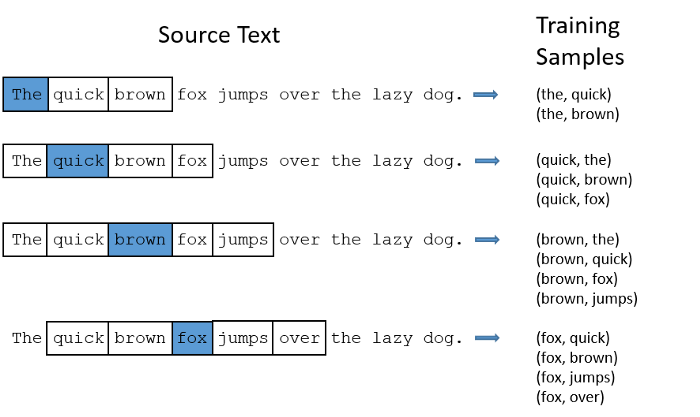

In [8]:
from IPython.display import Image
Image("imagens/skip_gram_trainsamples.png")

In [289]:
data_index = 0
# generate batch data
def generate_batch(data, batch_size, skip_window):
    global data_index
    num_skips = skip_window*2
    assert batch_size % num_skips == 0
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    context = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window palavra-alvo skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # seleciona a palavra do centro - alvo
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]  # palavra-alvo
            context[i * num_skips + j, 0] = buffer[target]  # palavras de contexto
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    data_index = (data_index + len(data) - span) % len(data)
    return batch, context

Testando a função definida acima:

In [290]:
print('Dados:', [dicionario_reverso[di] for di in data[0:100]])
print('Dados:', [dicionario_reverso[di] for di in data[-100:]])

len(data)

for window_size in [1, 2]:
    data_index = 0
    batch, labels = generate_batch(data, batch_size=8, skip_window=window_size)
    
    print('\nCom window_size = %d:' % (window_size))
    print('    batch:', [dicionario_reverso[bi] for bi in batch])
    print('    labels:', [dicionario_reverso[li] for li in labels.reshape(8)])
 

Dados: ['daqui', 'entro', 'repórter', 'comentarista', 'opinião', 'pago', 'opinião', 'análise', 'demonstro', 'humildade', 'especialista', 'coates', 'vá', 'ideologia', 'supremacismo', 'branco', 'tentará', 'pregar', 'peterson', 'pecha', 'fascista', 'sugerir', 'identitarismo', 'filosofia', 'horrível', 'leia', 'coluna', 'semana', 'manda', 'bomba', 'síria', 'decretos', 'reduzir', 'acesso', 'armas', 'cidadãos', 'americanos', 'metáfora', 'dada', 'epidemia', 'esquerda', 'autoritária', 'pra', 'avançar', 'tentáculos', 'leviatã', 'estatal', 'precisa', 'congresso', 'argentina', 'enorme', 'pedra', 'sapato', 'esquerda', 'premissa', 'consenso', 'científico', 'falsa', 'bolsonaro', 'disse', 'cedeu', 'pragmatismo', 'pressão', 'globalista', 'jogo', 'líderes', 'falem', 'manso', 'ditadura', 'chinesa', 'dia', 'presidentes', 'governo', 'federal', 'câmara', 'senado', 'stf', 'governadores', 'reunião', 'harmonia', 'coordenação', 'crise', 'insuspeito', 'jornal', 'tucano', 'condena', 'articulação', 'tucanos', 'pau

Esta função cria pequenos lotes (mini-batches) para usar durante o treinamento. Esses lotes consistirão em palavras-alvo de entrada, que serão armazenadas na variável `batch` e palavras de contexto associadas a ela que serão incluídas na variável `context` (ou labels).

Agora já é possível criar o modelo de treino do Word2Vec. Mas antes vamos criar um pequeno dataset de validação que será usado no meio do treinamento. Não confundir com os dados de teste que separamos anteriormente. Aqui iremos buscar algumas das palavras mais comuns do vocabulário geral para identificar alguns de seus vizinhos mais próximos e saber como o modelo está se comportando ao longo do treinamento.

In [292]:
# Amostra de validação para medir a similaridade no curso do treinamento
# O IDs baixos garantem que sejam palavras mais comuns
valid_size = 5     # Número de palavras coletadas aleatoriamente a serem centroides de similaridade
valid_window = 150  # Janela de palavras a serem escolhidas, neste caso, entre as 100 primeiras
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64

## 8. Criando o grafo do TensorFlow
Precisamos agora configurar a rede neural em que temos uma matriz de embeddings das palavras em uma camada oculta e uma função Softmax na camada de saída.

Primeiro, configuramos alguns dos hiperparâmetros do modelo:

In [325]:
batch_size = 128 #tamanho do lote
embedding_size = 256  # Dimensão do vetor de embedding, camada oculta da rede neural
skip_window = 8       # Raio da janela, ex: se skip_window = 1, a janela (ou span) terá 3 palavras: um alvo ao centro, 1 de contexto à esquerda e 1 de contexto à direita
vocabulary_size = len(dicionario) # O tamanho do vocabulário

Abaixo temos o desenho do grafo que será usado pelo Tensor Flow quando rodarmos o modelo:

In [326]:
tf.compat.v1.disable_eager_execution()

graph = tf.Graph()

with graph.as_default():
    
    # Dados de entrada
    train_inputs = tf.compat.v1.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.compat.v1.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    test_labels = tf.compat.v1.placeholder(tf.int32, shape=[batch_size],name='test_dataset')
    
    # Consulta de embeddings para as entradas
    embeddings = tf.Variable(tf.compat.v1.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    
    # Construção de variáveis para a camada Softmax (saída)
    weights = tf.Variable(tf.compat.v1.truncated_normal([embedding_size, vocabulary_size], 
                                                        stddev=1.0 / math.sqrt(embedding_size)))
    biases = tf.Variable(tf.zeros([vocabulary_size],dtype=tf.float32))
    hidden_out = tf.transpose(tf.matmul(tf.transpose(weights), tf.transpose(embed))) + biases

    # Converte os dados em codificação one-hot
    train_one_hot = tf.one_hot(train_labels, vocabulary_size)

    # Calcula a similaridade do coseno para as amostras
    norm = tf.sqrt(tf.math.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
    
    # Constrói a variável de perda
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=hidden_out, labels=train_one_hot))
    
    # Otimizador
    optimizer = tf.compat.v1.train.GradientDescentOptimizer(1.0).minimize(cross_entropy)
    
    # Inicializador
    init = tf.compat.v1.global_variables_initializer()

O primeiro passo do código acima é criar as variáveis para os embeddings que consistem exatamente nos pesos da conexão linear para a camada oculta. As variáveis são iniciadas com uma distribuição uniforme entre -1.0 e 1.0. O tamanho dessa variável é (tamanho_do_vocabulario, tamanho_do_embedding). No nosso estudo, o tamanho do vocabulário tem aproximadamente 28.000 palavras e o tamanho do embedding estamos ajustando para 256 dimensões, ou nodes da camada oculta. A camada de entrada será interface para reduzir as 28.000 para os 256 vetores da camada oculta. Este tensor `embeddings`pode ser imaginado como uma grande tabela de consulta.

O próximo tensor envolve a função `tf.nn.embedding_lookup()` que é uma função útil no TensorFlow para este tipo de tarefa, ou seja, localizar um entrada a partir de um índice, neste caso a palavra de entrada no treinamento.

Depois disso, são criadas as variáveis de peso (`weights`) e `biases`. Para otimizar os pesos, usaremos a função `softmax_cross_entropy_with_logits()`. Para usar essa função, é necessário converter os nossos índices (inteiros) de palavras para o formato one-hot (`train_one_hot`). Toda essa operação é realizada pelo Otimizador (`optimizer`) que minimiza o erro através de um otimizador gradiente descendente.

Next, we need to perform our similarity assessments to check on how the model is performing as it trains.  To determine which words are similar to each other, we need to perform some sort of operation that measures the “distances” between the various word embedding vectors for the different words.  In this case, we will use the cosine similarity measure of distance between vectors.  It is defined as:

Para fazer a nossa verificação de similaridade, usamos a métrica de similaridade do coseno. Primeiro é necessário calcular a normalização L2 de cada vetor (`tf.square()` -> `tf.reduce_sum()` -> `tf.sqrt()`), fazendo com que a simples multiplicação entre os embeddings resulte na similaridade do coseno.

## 9. Rodando o modelo do TensorFlow
O código abaixo inicializa as variáveis e alimenta lotes de dados (variável da data) a cada loop de treinamento, imprimindo a perda média a cada 2000 iterações. 

In [327]:
def run(graph, num_steps):
    with tf.compat.v1.Session(graph=graph) as session:
        # Inicializar as variáveis definidas anteriormente
        init.run()
        print('Inicializado...')

        average_loss = 0
        for step in range(num_steps):
            batch_inputs, batch_context = generate_batch(data, batch_size, skip_window)
            feed_dict = {train_inputs: batch_inputs, train_labels: batch_context}

            _, loss_val = session.run([optimizer, cross_entropy], feed_dict=feed_dict)
            average_loss += loss_val

            if step % 2000 == 0:
                if step > 0:
                    average_loss /= 2000
                # Perda estimada nos últimos 2000 passos
                print('Perda média no passo', step, ': ', average_loss)
                average_loss = 0

            # Roda apenas a cada 100000 passos
            if step % 100000 == 0:
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = dicionario_reverso[valid_examples[i]]
                    top_k = 8  # número de vizinhos mais próximos
                    nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                    log_str = 'Mais próximo de %s:' % valid_word
                    for k in range(top_k):
                        close_word = dicionario_reverso[nearest[k]]
                        log_str = '%s %s,' % (log_str, close_word)
                    print(log_str)
        return normalized_embeddings.eval()

Ajustamos então anguns parâmetros finais e iniciamos o treinamento:

In [328]:
num_steps = 100001
softmax_start_time = dt.datetime.now()
data_index = 0
final_embeddings = run(graph, num_steps=num_steps)
softmax_end_time = dt.datetime.now()
print("Finalizado. O método treinamento levou {} segundos para rodar 100001 iterações".format((softmax_end_time-softmax_start_time).total_seconds()))

Inicializado...
Perda média no passo 0 :  10.263917922973633
Mais próximo de sp: levo, passar, internar, dançou, duranty, novidade, existiram, associa,
Mais próximo de política: lacuna, começado, microponte, role, proíbe, down, acostumada, bolsoday,
Mais próximo de existe: miiiiiaaaauuu, senhoras, entenderia, catástrofe, toque, rage, somostodosdranise, visite,
Mais próximo de hoje: procurar, notas, animadinho, morrido, cedido, transcendentais, suspenderam, seriamente,
Mais próximo de paulo: laissezfairismo, resistente, servidor, gadismo, malvadonas, fiscalizações, bloquinhos, rodolffo,
Perda média no passo 2000 :  9.641933525323868
Perda média no passo 4000 :  9.25328679871559
Perda média no passo 6000 :  9.01779854273796
Perda média no passo 8000 :  9.09993089056015
Perda média no passo 10000 :  8.942927999019624
Perda média no passo 12000 :  8.919226205110549
Perda média no passo 14000 :  9.041553716421127
Perda média no passo 16000 :  9.005251473903655
Perda média no passo 18000 :  

Ao final do treinamento, retornamos a `normalized_embeddings` que é camada oculta de pesos, que trata-se exatamente das embeddings de palavras que foram treinadas pelo modelo e que usaremos para calcular as embeddings únicas para os autores e amostras de teste.

## 10. Visualizando o resultado do treinamento do Word2Vec
Podemos então criar uma visualização genérica para avaliar o resultado do treinamento. Abaixo reduzimos a dimensionalidade das embeddings das 500 palavras mais comuns com o TSN-E para que possamos plotar em duas dimensões.

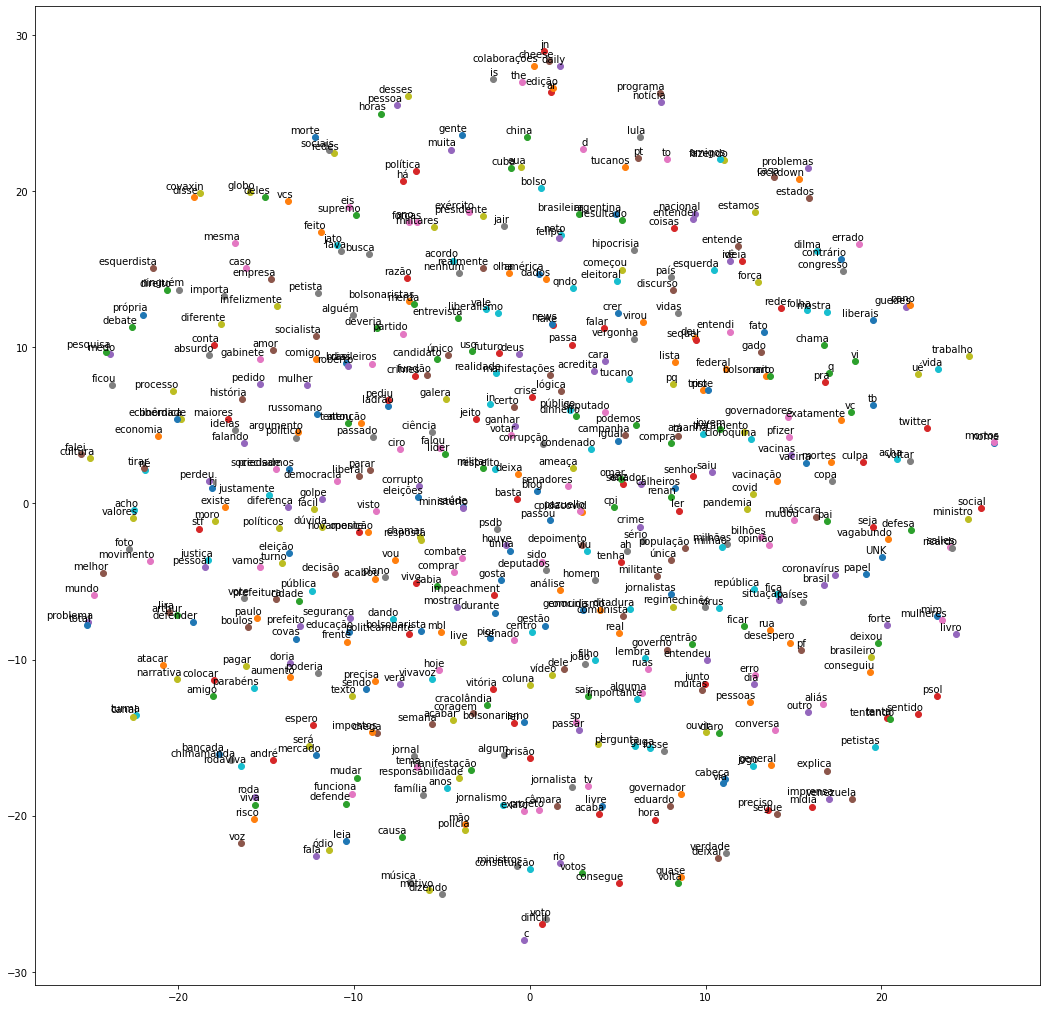

In [329]:
import warnings
warnings.filterwarnings("ignore") #suprimir warnings de fonts

plt = matplotlib.pyplot

def plot_with_labels(low_dim_embs, labels, filename='tsne2.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'Mais labels que embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.savefig(filename)

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [dicionario_reverso[i] for i in xrange(plot_only)]
plot_with_labels(low_dim_embs, labels)

### Salvando os embeddings treinados no sistema de arquivos do SO

In [330]:
arquivo_salvar = 'embeddings3.npy'
with open(arquivo_salvar, 'wb') as f:
    np.save(f, final_embeddings)

### Carregando os embeddings treinados do sistema de arquivos do SO

In [153]:
arquivo_carregar = 'embeddings.npy'
with open(arquivo_carregar, 'rb') as f:
    final_embeddings = np.load(f)

##  11. Criando embeddings únicos para cada autor e para cada entrada de teste
Para que possamos comparar os embeddings a nível de documento ou autoria, é necessário reduzir o vocabulário de embeddings de cada autor e cada amostra de teste para uma única embedding. A redução é realizada pela média dos embeddings de cada vocabulário.

In [331]:
# Tranformando os tokens em índices do dicionário e reduzindo os embeddings de teste
test_embeddings = {}

for aut, tokens in tokenizado_test.items():
    nome = aut + '_teste'
    test_data = build_dataset_com_dicionario(tokenizado_test[aut],dicionario)
    filtrado = final_embeddings[np.unique(test_data)]
    test_embeddings[nome] = np.mean(filtrado, 0)

# Tranformando os tokens em índices do dicionário e reduzindo os embeddings de treino
aut_embeddings = {}

for aut, tokens in tokenizado_train.items():
    train_data = build_dataset_com_dicionario(tokenizado_train[aut],dicionario)
    filtrado = final_embeddings[np.unique(train_data)]
    aut_embeddings[aut] = np.mean(filtrado, 0)

## 12. Criando uma matriz de distância para analisar a semelhança entre os diversos embeddings
Agora que temos os embeddings únicos, podemos medir a similariade/ distância entre os diversos autores treinados e amostras de teste. Abaixo unimos estes dois grupos em uma mesma matriz para que possamos analisar a relação entre os conjuntos de dados.

In [332]:
doc_ids, doc_embeddings = zip(*aut_embeddings.items())
doc_ids_test, doc_embeddings_test = zip(*test_embeddings.items())
doc_embeddings = doc_embeddings + doc_embeddings_test
doc_ids = doc_ids + doc_ids_test

matriz_distancia = []
for i in range(len(doc_embeddings)):
    linha=[]
    for j in range(len(doc_embeddings)):
        [[valor]] = sklearn.metrics.pairwise.cosine_similarity(doc_embeddings[i].reshape(1, -1), doc_embeddings[j].reshape(1, -1))
        if (valor > 1):
            valor=1
        linha.append(round(1.0-valor, 6))
    matriz_distancia.append(linha)

In [333]:
matriz_distancia = pd.DataFrame(matriz_distancia)
matriz_distancia = matriz_distancia.rename(
    columns={0:'rc', 1:'pd', 2:'rm', 3:'av', 4:'vm', 5:'rc_teste', 6:'pd_teste', 7:'rm_teste', 8:'av_teste', 9:'vm_teste'},
    index={0:'rc', 1:'pd', 2:'rm', 3:'av', 4:'vm', 5:'rc_teste', 6:'pd_teste', 7:'rm_teste', 8:'av_teste', 9:'vm_teste'})
display(matriz_distancia)

,rc,pd,rm,av,vm,rc_teste,pd_teste,rm_teste,av_teste,vm_teste
rc,0.000000,0.179672,0.203003,0.179540,0.200691,0.128353,0.209954,0.261252,0.198500,0.238644
pd,0.179672,0.000000,0.238507,0.201506,0.270536,0.214291,0.117982,0.287053,0.201648,0.252967
rm,0.203003,0.238507,0.000000,0.258202,0.250142,0.202833,0.294150,0.197747,0.271899,0.284063
av,0.179540,0.201506,0.258202,0.000000,0.240138,0.218540,0.246716,0.272799,0.097323,0.258107
vm,0.200691,0.270536,0.250142,0.240138,0.000000,0.258867,0.299415,0.306410,0.285112,0.174839
rc_teste,0.128353,0.214291,0.202833,0.218540,0.258867,0.000000,0.213583,0.255137,0.213038,0.289898
pd_teste,0.209954,0.117982,0.294150,0.246716,0.299415,0.213583,0.000000,0.357378,0.248276,0.302281
rm_teste,0.261252,0.287053,0.197747,0.272799,0.306410,0.255137,0.357378,0.000000,0.288413,0.334496
av_teste,0.198500,0.201648,0.271899,0.097323,0.285112,0.213038,0.248276,0.288413,0.000000,0.251993
vm_teste,0.238644,0.252967,0.284063,0.258107,0.174839,0.289898,0.302281,0.334496,0.251993,0.000000


### 12.1 Fazendo um recorte apenas nos dados de relação treino-teste
Excluindo a relação treino-treino e teste-teste. Preparando para plotar a matriz de distância

In [334]:
matriz_recorte = matriz_distancia.iloc[5:,:5]
display(matriz_recorte)

,rc,pd,rm,av,vm
rc_teste,0.128353,0.214291,0.202833,0.218540,0.258867
pd_teste,0.209954,0.117982,0.294150,0.246716,0.299415
rm_teste,0.261252,0.287053,0.197747,0.272799,0.306410
av_teste,0.198500,0.201648,0.271899,0.097323,0.285112
vm_teste,0.238644,0.252967,0.284063,0.258107,0.174839


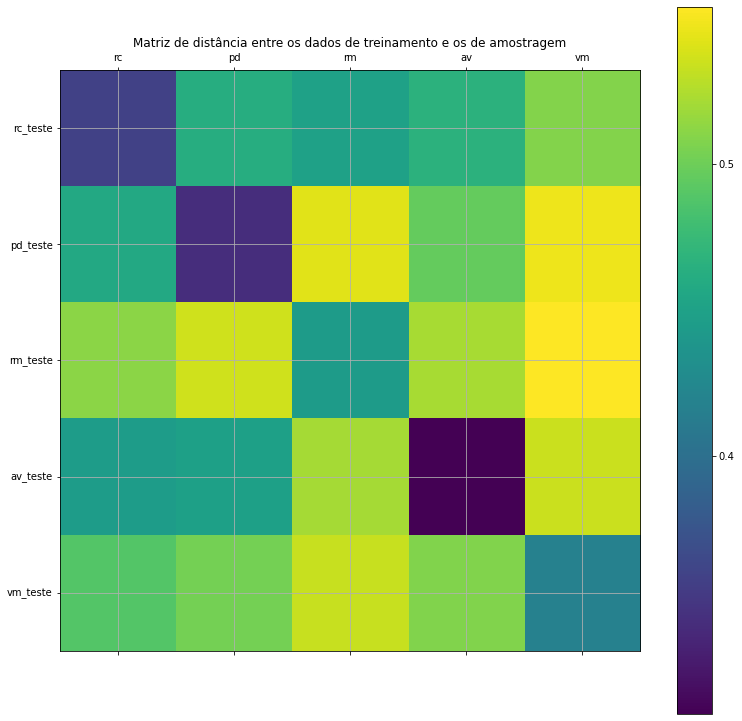

In [335]:
fig, ax = plt.subplots(figsize=(13,13))
cax = ax.matshow(np.sqrt(matriz_recorte), interpolation='nearest')
ax.grid(True)
plt.title('Matriz de distância entre os dados de treinamento e os de amostragem')
plt.xticks(range(5), doc_ids[:5]);
plt.yticks(range(5), doc_ids_test);
fig.colorbar(cax, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
plt.show()

É possível verificar que em cada linha da matriz temos uma área mais escura que sinaliza a proximidade maior entre os embeddings. O padrão observável de diagonal descendente sinaliza que as amostras de validação guardam identidade próxima às suas respectivas assinaturas autorais. Exceto o rm_teste não é claramente identificável pois guarda forte relação formal com rc também.

## 13. Utilizando os algoritmos de classificação Centróide Mais Próximo  (NearestCentroid) e Regressão Logistica (Logistic Regression) para predição das entradas de teste

In [336]:
#Dataframes de dados
X_train = pd.DataFrame.from_dict(aut_embeddings, 'index')
X_test = pd.DataFrame.from_dict(test_embeddings, 'index')

#Dataframes de labels
y_train = X_train.index
y_test = y_train

#Para exibir resultado final do modelo
str_acu = 'Acurácia total do modelo para 5 classes treinadas e 5 amostras de teste: '

### 13.1 Centróide Mais Próximo

Vimos acima que os embeddings de teste possuem correlações mais próximas para com alguns dos embeddings de treino. Vamos ver como um modelo de classificação se sairia com os dados coletados. Utilizaremos um algoritmo simples de vizinhança, o `NearestCentroid`, ou "centróide mais próximo", para esta tarefa.

In [337]:
clf = NearestCentroid(metric='cosine')
clf.fit(X_train, y_train)

NearestCentroid(metric='cosine')

In [338]:
tabela_predict = [list(y_test)]

#faz a previsão dos dados de teste e apensa na tabela
tabela_predict.append(clf.predict(X_test).tolist())

#formata a tabela e acrecenta a coluna de acurácia
tabela_predict = pd.DataFrame.from_dict(tabela_predict)
tabela_predict = tabela_predict.transpose()
tabela_predict = tabela_predict.rename(columns={0: 'autor', 1: 'predicao'})
tabela_predict['acuracia'] = np.where(tabela_predict.autor == tabela_predict.predicao, 1, 0)

In [339]:
tabela_predict = tabela_predict.rename(
    columns={'autor': 'Autor da amostra', 'predicao': 'Predição', 'acuracia': 'Acurácia'},
    index={0: 'rc_teste', 1: 'pd_teste', 2: 'rm_teste', 3: 'av_teste', 4: 'vm_teste'})

print('\nNearestCentroid -> algoritmo "cosine"')

display(tabela_predict)
print(str_acu, clf.score(X_test, y_test))


NearestCentroid -> algoritmo "cosine"


,Autor da amostra,Predição,Acurácia
rc_teste,rc,rc,1
pd_teste,pd,pd,1
rm_teste,rm,rm,1
av_teste,av,av,1
vm_teste,vm,vm,1


Acurácia total do modelo para 5 classes treinadas e 5 amostras de teste:  1.0


O modelo teve uma acurácia de 100%, porém, lembrando que estamos trabalhando com uma amostragem bastante restrita, mas suficiente para atestar que as embeddings aprendidas pelo modelo Word2Vec podem ser usadas também para a classificação de documentos ou, como neste caso específico, para a classificação por autores. Embora o Centróide mais Próximo com algoritmo de similaridade do coseno seja o modelo preferível de classificação por estar alinhado com a matriz de similaridade de vetores realizada acima, para efeitos de comparação, aplicaremos também um modelo de Regressão Logística aos embeddings de classes.

### 13.2 Regressão Logística

In [340]:
clf2 = LogisticRegression(random_state=0, solver='saga').fit(X_train, y_train)

In [341]:
tabela_predict2 = [list(y_test)]

#faz a previsão dos dados de teste e apensa na tabela
tabela_predict2.append(clf2.predict(X_test).tolist())

#formata a tabela e acrecenta a coluna de acurácia
tabela_predict2 = pd.DataFrame.from_dict(tabela_predict2)
tabela_predict2 = tabela_predict2.transpose()
tabela_predict2 = tabela_predict2.rename(columns={0: 'autor', 1: 'predicao'})
tabela_predict2['acuracia'] = np.where(tabela_predict2.autor == tabela_predict2.predicao, 1, 0)

In [342]:
tabela_predict2 = tabela_predict2.rename(
    columns={'autor': 'Autor da amostra', 'predicao': 'Predição', 'acuracia': 'Acurácia'},
    index={0: 'rc_teste', 1: 'pd_teste', 2: 'rm_teste', 3: 'av_teste', 4: 'vm_teste'})

print('\nLogisticRegression -> algoritmo "saga"')

display(tabela_predict2)
print(str_acu, clf2.score(X_test, y_test))


LogisticRegression -> algoritmo "saga"


,Autor da amostra,Predição,Acurácia
rc_teste,rc,rc,1
pd_teste,pd,pd,1
rm_teste,rm,rm,1
av_teste,av,av,1
vm_teste,vm,vm,1


Acurácia total do modelo para 5 classes treinadas e 5 amostras de teste:  1.0


### 13.3 Algoritmos com performance menor
Nenhum dos modelos de classificação escolhidos (NearestCentroid e Logistic Regression) funcionaram bem em seus parâmetros padrão. Porém, a alteração no algoritmo de métrica resultou em 100% de aproveitamento para ambos os casos. A otimização realizada foi:
- NearestCentroid(metric='euclidean'*padrão) -> NearestCentroid(metric='cosine')
- LogisticRegression(solver='lbfgs'*padrão) -> LogisticRegression(solver='saga')

É natural pois a distância euclidiana não é tão eficiente quanto a similaridade do coseno para vetores multidimensionais. A regressão logística costuma ser mais eficiente para uma grande amostra de treinamento e teste, o que não é o caso.

Na segunda iteração, ao rodar o Word2Vec com skip_window = 8, os 4 algoritmos atingiram 100% de acurácia.

In [343]:
clf3 = NearestCentroid().fit(X_train, y_train)

In [344]:
clf3.predict(X_test)

array(['rc', 'pd', 'rm', 'av', 'vm'], dtype=object)

In [345]:
print('\nNearestCentroid -> algoritmo "euclidean" - padrão')
print(str_acu, clf3.score(X_test, y_test))


NearestCentroid -> algoritmo "euclidean" - padrão
Acurácia total do modelo para 5 classes treinadas e 5 amostras de teste:  1.0


In [346]:
clf4 = LogisticRegression(random_state=0).fit(X_train, y_train)

In [347]:
clf4.predict(X_test)

array(['rc', 'pd', 'rm', 'av', 'vm'], dtype=object)

In [348]:
print('\nLogisticRegression -> algoritmo "lbfgs" - padrão')
print(str_acu, clf4.score(X_test, y_test))


LogisticRegression -> algoritmo "lbfgs" - padrão
Acurácia total do modelo para 5 classes treinadas e 5 amostras de teste:  1.0


## 14. Resultado final

In [352]:
resultado = pd.DataFrame([{'Nº da iteração':'1', 
                           'Parâmetros Word2Vec':'skip_window-4 e 100k passos',
                           'Duração do treino':'47 minutos',
                           'Loss no último passo':'7.12',
                          'Algoritmo de Classificação':'NearestCentroid-cosine',
                          'Acurácia':'1.0'},
                          {'Nº da iteração':'1', 
                           'Parâmetros Word2Vec':'skip_window-4 e 100k passos',
                           'Duração do treino':'47 minutos',
                           'Loss no último passo':'7.12',
                          'Algoritmo de Classificação':'NearestCentroid-euclidean',
                          'Acurácia':'0.8'},
                          {'Nº da iteração':'1', 
                           'Parâmetros Word2Vec':'skip_window-4 e 100k passos',
                           'Duração do treino':'47 minutos',
                           'Loss no último passo':'7.12',
                          'Algoritmo de Classificação':'LinearRegression-saga',
                          'Acurácia':'1.0'},
                          {'Nº da iteração':'1', 
                           'Parâmetros Word2Vec':'skip_window-4 e 100k passos',
                           'Duração do treino':'47 minutos',
                           'Loss no último passo':'7.12',
                          'Algoritmo de Classificação':'LinearRegression-lbfgs',
                          'Acurácia':'0.4'},
                          {'Nº da iteração':'2', 
                           'Parâmetros Word2Vec':'skip_window-8 e 100k passos',
                           'Duração do treino':'95 minutos',
                           'Loss no último passo':'7.84',
                          'Algoritmo de Classificação':'NearestCentroid-cosine',
                          'Acurácia':'1.0'},
                          {'Nº da iteração':'2', 
                           'Parâmetros Word2Vec':'skip_window-8 e 100k passos',
                           'Duração do treino':'95 minutos',
                           'Loss no último passo':'7.84',
                          'Algoritmo de Classificação':'NearestCentroid-euclidean',
                          'Acurácia':'1.0'},
                          {'Nº da iteração':'2', 
                           'Parâmetros Word2Vec':'skip_window-8 e 100k passos',
                           'Duração do treino':'95 minutos',
                           'Loss no último passo':'7.84',
                          'Algoritmo de Classificação':'LinearRegression-saga',
                          'Acurácia':'1.0'},
                          {'Nº da iteração':'2', 
                           'Parâmetros Word2Vec':'skip_window-8 e 100k passos',
                           'Duração do treino':'95 minutos',
                           'Loss no último passo':'7.84',
                          'Algoritmo de Classificação':'LinearRegression-lbfgs',
                          'Acurácia':'1.0'}
                         ])
display(resultado)

,Nº da iteração,Parâmetros Word2Vec,Duração do treino,Loss no último passo,Algoritmo de Classificação,Acurácia
0,1,skip_window-4 e 100k passos,47 minutos,7.12,NearestCentroid-cosine,1.0
1,1,skip_window-4 e 100k passos,47 minutos,7.12,NearestCentroid-euclidean,0.8
2,1,skip_window-4 e 100k passos,47 minutos,7.12,LinearRegression-saga,1.0
3,1,skip_window-4 e 100k passos,47 minutos,7.12,LinearRegression-lbfgs,0.4
4,2,skip_window-8 e 100k passos,95 minutos,7.84,NearestCentroid-cosine,1.0
5,2,skip_window-8 e 100k passos,95 minutos,7.84,NearestCentroid-euclidean,1.0
6,2,skip_window-8 e 100k passos,95 minutos,7.84,LinearRegression-saga,1.0
7,2,skip_window-8 e 100k passos,95 minutos,7.84,LinearRegression-lbfgs,1.0
